In [1]:
import sys

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

sys.path.append('..')
from sketched.sketched import DiscreteSpectrum, SketchedEquivalence, JointSketchingEquivalence, get_orthogonal_equiv
from sketched._sketches import CountSketch, FastJohnsonLindenstraussSketch, fht

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2170.18it/s]


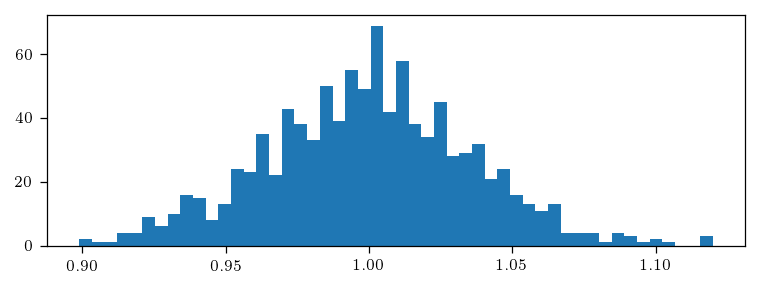

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1205.46it/s]


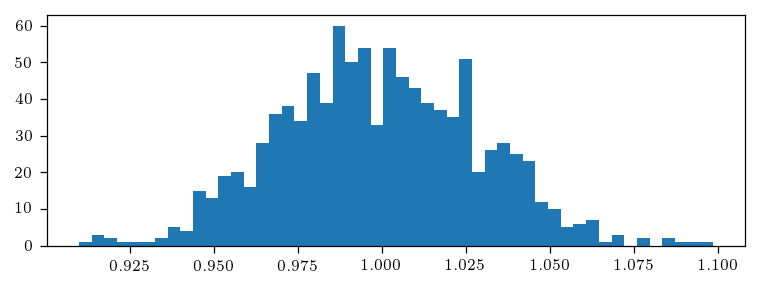

In [3]:
# check that sketches are indeed normalized

p = 1200
n_trials = 1000

y_norms = []

for t in tqdm(range(n_trials)):
    t = int(10 * np.log(p))
    b = 600 // t
    cs = CountSketch(t, 600 // t, p, normed=True)
    x = np.random.randn(p) / np.sqrt(p)
    y = cs @ x
    y_norms.append(np.linalg.norm(y))
    
plt.hist(y_norms, 50)
plt.show()

y_norms = []

for t in tqdm(range(n_trials)):
    cs = FastJohnsonLindenstraussSketch(700, p, 0.01, perm=True, ortho=True, normed=True)
    x = np.random.randn(p) / np.sqrt(p)
    y = cs @ x
    y_norms.append(np.linalg.norm(y))
    
plt.hist(y_norms, 50)
plt.show()

In [4]:
class FJLTBuilder(object):
    
    def __init__(self, alpha, ortho=False):
        
        self.alpha = alpha
        self.ortho = ortho
    
    def __call__(self, p):
        
        k = int(self.alpha * p)
        q = min(1, 10 / p)
        #q = 0.001
        
        return FastJohnsonLindenstraussSketch(k, p, q, ortho=self.ortho, perm=False, normed=True)
    
class CountSketchBuilder(object):
    
    def __init__(self, alpha):
        
        self.alpha = alpha
    
    def __call__(self, p):
        
        t = int(10 * max(1, np.log(p)))
        b = int(max(1, self.alpha * p / t))
        #print(t, b)
        
        #b = int(np.sqrt(alpha * p))
        #t = int(np.sqrt(alpha * p))
        
        return CountSketch(b, t, p, normed=True) # * np.sqrt(t * b / (self.alpha * p))

class OrthoSketchBuilder(object):
    
    def __init__(self, alpha):
        
        self.alpha = alpha
    
    def __call__(self, p):
        
        q = int(self.alpha * p)
        
        S, _ = np.linalg.qr(np.random.randn(p, q))
        return S.T * np.sqrt(p / q)

class AdaptiveSketchBuilder(object):
    
    def __init__(self, alpha):
        
        self.alpha = alpha
    
    def __call__(self, p):
        
        q = int(self.alpha * p)
    
        # uses a from global context
        long_a = np.repeat(a, p // len(a))
        
        S, _ = np.linalg.qr(long_a[:, None] ** 0.5 * np.random.randn(p, q))
        return S.T * np.sqrt(p / q)

In [5]:
def scaled_up_and_sketched_resolvent(a, sketch_builder, k=1, lamda=1.0):
    
    a = np.repeat(a, k)
    p = len(a)
    
    A = np.diag(a)
    
    S = (sketch_builder(p) @ np.eye(p)).T
    
    q = S.shape[1]
    
    return S @ np.linalg.solve(S.T @ A @ S + lamda * np.eye(q), S.T)

def get_diags_and_off_diags(A):
    
    off_diag_mask = np.logical_not(np.eye(A.shape[0], dtype=bool))
    
    return np.diag(A), A[off_diag_mask]

a = np.asarray([0, 1, 2])
alpha = 0.8
lamda = 1
ks_st = [20, 100, 500]
ks_2_lo = [21, 85, 341]
ks_2_hi = [22, 86, 342]
n_trials = 20
n_bins = 150

np.random.seed(0)

settings = [
    {
        'name': 'Orthogonal',
        'builder': OrthoSketchBuilder(alpha),
        'ks': ks_st
    },
    {
        'name': 'CountSketch',
        'builder': CountSketchBuilder(alpha),
        'ks': ks_st
    },
    {
        'name': 'AdaptiveSketch',
        'builder': AdaptiveSketchBuilder(alpha),
        'ks': ks_st
    },
    {
        'name': 'FJLT',
        'builder': FJLTBuilder(alpha, ortho=False),
        'ks': ks_st
    },
    {
        'name': r'SRHT ($p \nearrow 2^d$)',
        'builder': FJLTBuilder(alpha, ortho=True),
        'ks': ks_2_lo
    },
    {
        'name': r'SRHT ($p \searrow 2^d$)',
        'builder': FJLTBuilder(alpha, ortho=True),
        'ks': ks_2_hi
    }
]

se = SketchedEquivalence(DiscreteSpectrum(a), alpha)
mu = se.get_mu_from_lamda(lamda)
gamma = get_orthogonal_equiv(DiscreteSpectrum(a), alpha, lamda)
print(mu, gamma)

all_diags = []

for j, setting in enumerate(settings):
    
    print(setting['name'])
    all_diags.append([])
    
    for i, k in enumerate(setting['ks']):

        diags = np.array([])
        off_diags = np.array([])
        

        for _ in tqdm(range(n_trials)):
            sketch = scaled_up_and_sketched_resolvent(a, setting['builder'], k, lamda)
            d, od = get_diags_and_off_diags(sketch)
            diags = np.concatenate([diags, d])
            off_diags = np.concatenate([off_diags, od])
        
        all_diags[-1].append(diags)


1.6329931618554339 1.1672219077226569
Orthogonal


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


CountSketch


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.63it/s]


AdaptiveSketch


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


FJLT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.33it/s]


SRHT ($p \nearrow 2^d$)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.50it/s]


SRHT ($p \searrow 2^d$)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.17it/s]


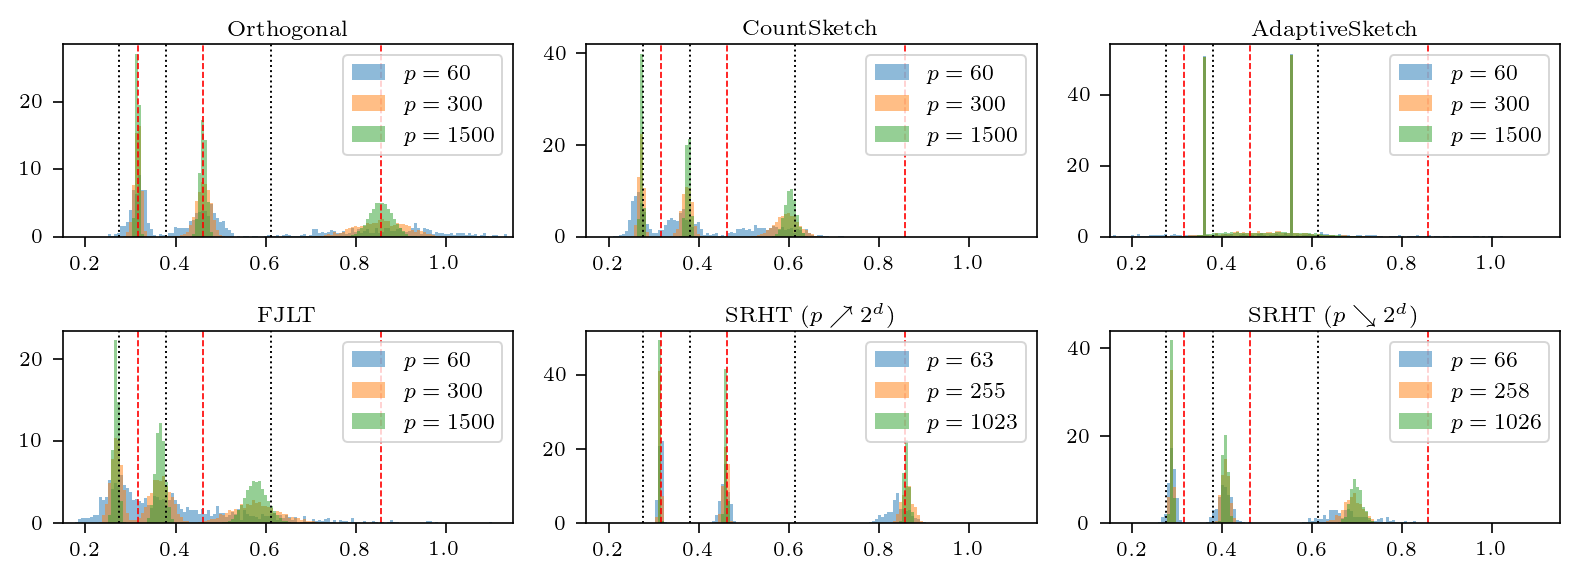

In [6]:
n_bins = 150
diag_bins = np.linspace(0.15, 1.15, n_bins + 1)

plt.figure(figsize=(8, 3), dpi=200)

for j, (setting, diags) in enumerate(zip(settings, all_diags)):
    
    for i, k in enumerate(setting['ks']):
    
        plt.subplot(2, 3, j + 1)
        plt.hist(diags[i], diag_bins, density=True, alpha=0.5, label=f'$p={k * len(a)}$')

    ylim = plt.ylim()
    for x in a:
        plt.plot(1 / (np.asarray([x, x]) + mu), ylim, ':k')
        plt.plot(1 / (np.asarray([x, x]) + gamma), ylim, '--r', linewidth=0.6)
        
    plt.ylim(ylim)
    plt.xlim(min(diag_bins), max(diag_bins))
    
    plt.legend(loc='upper right')
    
    plt.title(setting['name'])

plt.tight_layout()
plt.savefig('practical_concentration.pdf', bbox_inches='tight')
plt.show()